In [ ]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.2 MB 6.3 MB/s 
     |████████████████████████████████| 281 kB 64.8 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


# **Loading Dataset**

In [ ]:
import dgl

g = dgl.DGLGraph()
g.add_nodes(34)  # 34 members of the club labelled from 0-33
edge_list = [
    (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
    (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0),
    (7, 1), (7, 2), (7, 3), (8, 0), (8, 2), (9, 2),
    (10, 0), (10, 4), (10, 5), (11, 0), (12, 0), 
    (12, 3), (13, 0), (13, 1), (13, 2), (13, 3), 
    (16, 5), (16, 6), (17, 0), (17, 1), (19, 0),
    (19, 1), (21, 0), (21, 1), (25, 23), (25, 24),
    (27, 2), (27, 23), (27, 24), (28, 2), (29, 23),
    (29, 26), (30, 1), (30, 8), (31, 0), (31, 24),
    (31, 25), (31, 28), (32, 2), (32, 8), (32, 14),
    (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
    (32, 29), (32, 30), (32, 31), (33, 8), (33, 9),
    (33, 13), (33, 14), (33, 15), (33, 18), (33, 19),
    (33, 20), (33, 22), (33, 23), (33, 26), (33, 27),
    (33, 28), (33, 29), (33, 30), (33, 31), (33, 32)
]
src, dst = list(zip(*edge_list))
g.add_edges(src, dst)
g.add_edges(dst, src)

/usr/local/lib/python3.7/dist-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


# **Visualizing Graph**

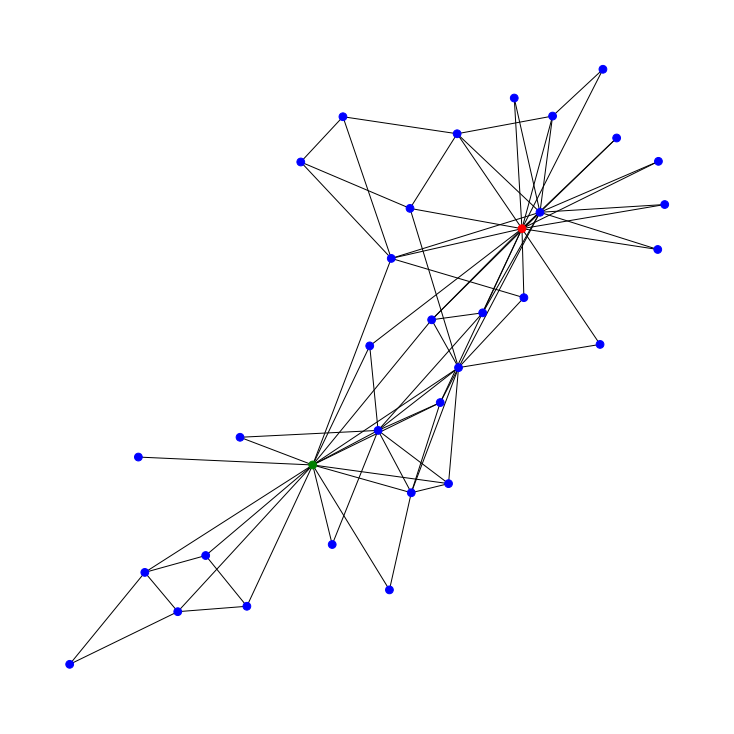

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

options = {
    'node_color': ['green'] + ['blue']*32 + ['red'],
    'edge_color': 'black',
    'node_size': 60,
    'width': 1,
}
G = dgl.to_networkx(g).to_undirected()
plt.figure(figsize=[10,10])
nx.draw(G, **options)

# **Message Passing Layer**

In [ ]:
import torch.nn as nn
import dgl.function as fn

class MessagePassingLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(MessagePassingLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        g.ndata["h"] = inputs
        g.send_and_recv(
            g.edges(),
            fn.copy_src("h", "m"),
            fn.sum("m", "h")
        )
        h = g.ndata.pop("h")
        return self.linear(h)

# **GNN Model**

In [ ]:
import torch

class GNN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GNN, self).__init__()
        self.gcn1 = MessagePassingLayer(in_feats, hidden_size)
        self.gcn2 = MessagePassingLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

# **Training**

In [ ]:
import torch.nn.functional as F


classes = [0, 1]
hidden_size = 5

net = GNN(g.num_nodes(), hidden_size, len(classes))
inputs = torch.eye(g.num_nodes())
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0, 1])

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

for epoch in range(20):
    logits = net(g, inputs)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("Epoch %d | Loss: %.4f" % (epoch, loss.item()))

Epoch 0 | Loss: 1.6590
Epoch 1 | Loss: 0.9771
Epoch 2 | Loss: 0.5651
Epoch 3 | Loss: 0.4640
Epoch 4 | Loss: 0.4026
Epoch 5 | Loss: 0.3062
Epoch 6 | Loss: 0.2030
Epoch 7 | Loss: 0.1255
Epoch 8 | Loss: 0.0783
Epoch 9 | Loss: 0.0526
Epoch 10 | Loss: 0.0391
Epoch 11 | Loss: 0.0314
Epoch 12 | Loss: 0.0267
Epoch 13 | Loss: 0.0234
Epoch 14 | Loss: 0.0209
Epoch 15 | Loss: 0.0188
Epoch 16 | Loss: 0.0170
Epoch 17 | Loss: 0.0153
Epoch 18 | Loss: 0.0138
Epoch 19 | Loss: 0.0124


# **Evaluation**


In [ ]:
from sklearn.metrics import classification_report


net.eval()
logits = net(g, inputs)
pred = F.log_softmax(logits, 1).argmax(dim=-1)

karate_club_dataset = dgl.data.KarateClubDataset()
ground_truth = karate_club_dataset[0].ndata["label"]

print(
    classification_report(
        ground_truth.tolist(), pred.tolist(), target_names=["0", "1"]
    )
)

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        17
           1       0.89      1.00      0.94        17

    accuracy                           0.94        34
   macro avg       0.95      0.94      0.94        34
weighted avg       0.95      0.94      0.94        34



# **Visualizing Result**

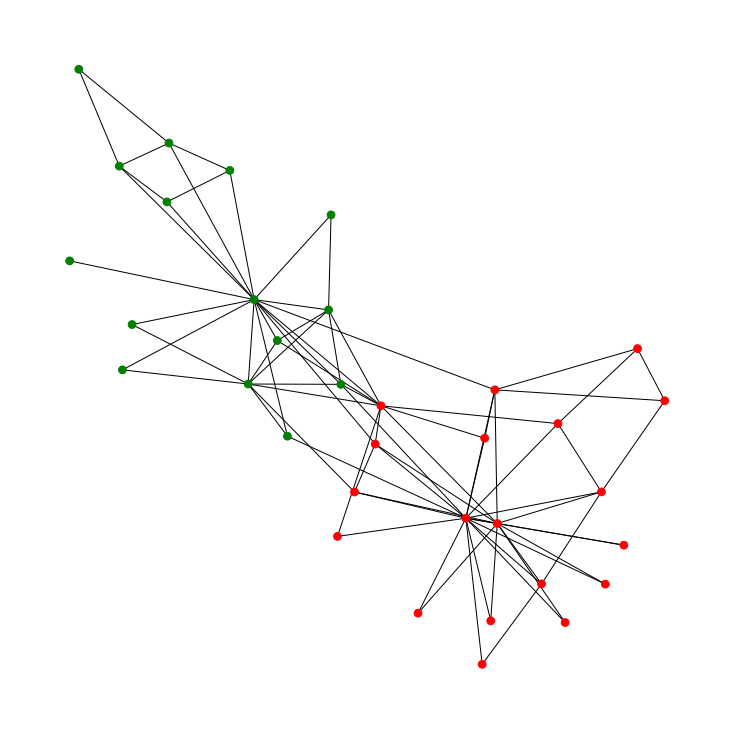

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

options = {
    'node_color': ["green" if prediction == 0 else "red" for prediction in pred.tolist()],
    'edge_color': 'black',
    'node_size': 60,
    'width': 1,
}
G = dgl.to_networkx(g).to_undirected()
plt.figure(figsize=[10,10])
nx.draw(G, **options)